## Adaboosting, Gradient Boosting, XGBoost Classifier

we will be working with a fake advertising data set, indicating whether or not a particular internet user clicked on an Advertisement on a company website. We will try to create a model that will predict whether or not they will click on an ad based off the features of that user.

This data set contains the following features:

* 'Daily Time Spent on Site': consumer time on site in minutes
* 'Age': cutomer age in years
* 'Area Income': Avg. Income of geographical area of consumer
* 'Daily Internet Usage': Avg. minutes a day consumer is on the internet
* 'Ad Topic Line': Headline of the advertisement
* 'City': City of consumer
* 'Male': Whether or not consumer was male
* 'Country': Country of consumer
* 'Timestamp': Time at which consumer clicked on Ad or closed window
* 'Clicked on Ad': 0 or 1 indicated clicking on Ad

## Import Libraries

In [1]:
# !pip install xgboost==1.7.3
# conda install -c conda-forge xgboost

In [2]:
import xgboost as xgb

xgb.__version__

'1.7.5'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (7,4)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [4]:
df = pd.read_csv('advertising2.csv')
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


## Exploratory Data Analysis and Visualization

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


In [6]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


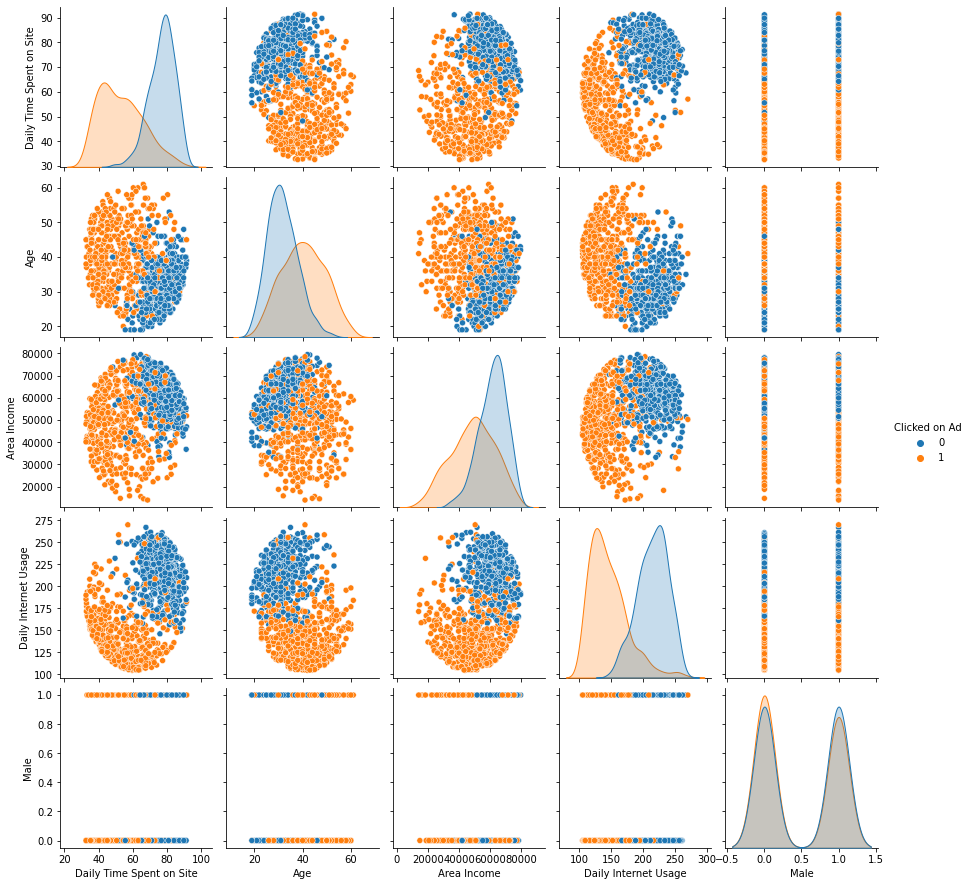

In [7]:
sns.pairplot(df, hue='Clicked on Ad')

## Train | Test Split

In [8]:
for feature in df.select_dtypes("object").columns:
    print(feature, df[feature].nunique())
               
# Kategorik featureların unique gözlem sayılarını tespit ediyoruz.
# çok fazla unique kategorik gözlem barındıran featurları drop edeceğiz. Hatırlarsanız çok fazla unique kategorik gözlem
# barındıran featurlara tree based modeller çok fazla ağırlık atayabiliyordu. Hem de model sayısı az olan unique kategorik 
# gözlemlerden birşey öğrenemiyordu.

Ad Topic Line 1000
City 969
Country 237
Timestamp 1000


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
cat = df.select_dtypes("object").columns
cat

# öncelikle kategorik featurları tespit ediyoruz. Bunları zaten yukarda drop etmeye karar vermiştik.

Index(['Ad Topic Line', 'City', 'Country', 'Timestamp'], dtype='object')

In [11]:
list(cat)

['Ad Topic Line', 'City', 'Country', 'Timestamp']

In [12]:
cat2 = list(cat) + ['Clicked on Ad']
cat2

# drop edeceğimiz feturlara targetımızı da ilave edip sonra X'den (bağımsız değişkenlerden) drop edeceğiz. 

['Ad Topic Line', 'City', 'Country', 'Timestamp', 'Clicked on Ad']

In [13]:
X = df.drop(columns=cat2)
y = df['Clicked on Ad']

# X ve y'mizi belirledik.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [15]:
X_train.head(1)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male
716,39.96,35,53898.89,138.52,1


## Modelling and Model Performance

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 
# Adoboost'un arkaplanında default olarak belirlenmiş base_estimator
# DecisionTreeClassifier olduğundan bunun içindeki hyperparametrelerle 
# oynamak istersek nasıl yapacağımızı göstermek için import ettik.
from sklearn.metrics import confusion_matrix, classification_report,\
                            accuracy_score, recall_score, precision_score,\
                            f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

In [17]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [18]:
#base_estimator=DecisionTreeClassifier(max_depth=1)
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)

In [19]:
ada_model.fit(X_train,y_train)

AdaBoostClassifier(random_state=42)

In [20]:
eval_metric(ada_model, X_train, y_train, X_test, y_test)

# overfiting yok görünüyor. CV ile teyit edeceğiz.

Test_Set
[[41  3]
 [ 4 52]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        44
           1       0.95      0.93      0.94        56

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100


Train_Set
[[454   2]
 [ 12 432]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       456
           1       1.00      0.97      0.98       444

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



In [21]:
model = AdaBoostClassifier(n_estimators=50, random_state=42)

scores = cross_validate(model, 
                        X_train, 
                        y_train, 
                        scoring=["accuracy",
                                 "precision",
                                 "recall", 
                                 "f1"], 
                       cv = 10,
                       return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# overfiting olmadığını gördük.

test_accuracy      0.961111
train_accuracy     0.985802
test_precision     0.968795
train_precision    0.996678
test_recall        0.952727
train_recall       0.974471
test_f1            0.960164
train_f1           0.985440
dtype: float64

## Tree Visualization

In [22]:
from sklearn.tree import plot_tree

In [23]:
model = AdaBoostClassifier(n_estimators=3, random_state=42)
model.fit(X_train,y_train)

# sadece 3 agaç görselleştirip çalışma mantığına değineceğiz.

AdaBoostClassifier(n_estimators=3, random_state=42)

In [24]:
# targets = df["Clicked on Ad"].astype("str")

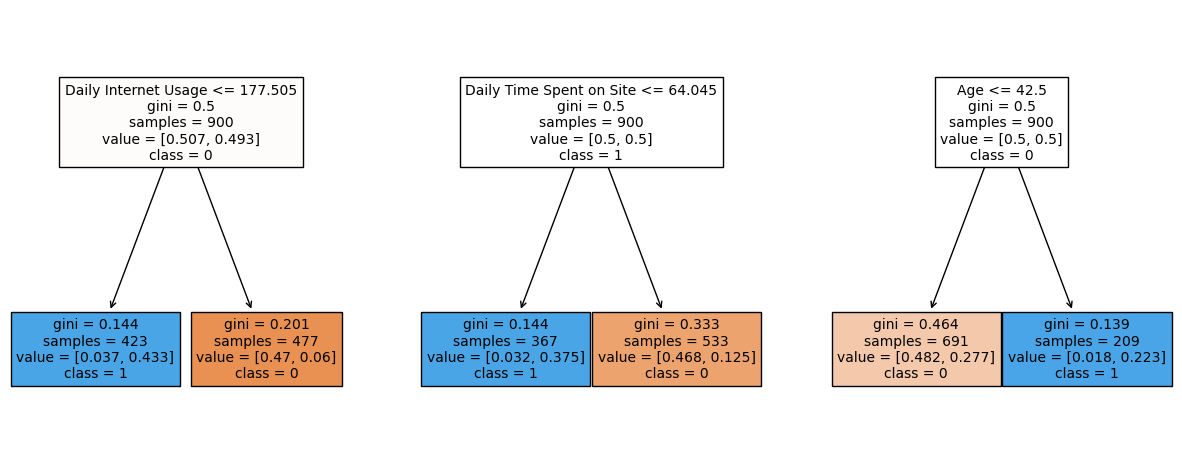

In [25]:
#features = list(X.columns)
targets = df["Clicked on Ad"].astype("str")
plt.figure(figsize=(15,6),dpi=100)
for i in range(3):  
  plt.subplot(1,3,i+1)
  plot_tree(model.estimators_[i], 
            filled=True, 
            feature_names=X.columns, 
            class_names=targets.unique(), 
            fontsize=10);

# targetleri stringe çevirmemiz gerekiyor. Yoksa hata alırsınız.

# adaboostclassifier her agacında train setindeki gözlem sayısı kadar gözlem olur ama her agaçta bu gözlemler değişir.
# adaboostclassifier tahmin edemediği gözlemleri bir sonraki agaca bildirip bu gözlemlere daha fazla ağırlık verilmesini ister.
# Bu ağırlıklandırmaya tahmin edilemeyen gözlemlerin sayısının bir sonraki agaçta artırılmasına denir. Tahmin edilen 
# gözlemlerin bazıları ise bir sonraki agaca aktarılmaz.
# Sonraki agaçlardaki gözlemlerin ağırlıklandırılması learning rate ile düzenlenir.

# şimdi çalışma mantığını anlamak için aşağıdaki gözlemi 3 ayrı agaçtada tahmin edelim.

# Daily Time Spent on Site       68.95
# Age                            35.00
# Area Income                 61833.90
# Daily Internet Usage          156.09
# Male                            0.00

# 1. agaç 1 olarak tahmin etti. Agacın ağırlık katsayısı 1.117
# 2. agaç 0 olarak tahmin etti. Agacın ağırlık katsayısı 0.841
# 3. agaç 0 olarak tahmin etti. Agacın ağırlık katsayısı 0.434


# 0 classını tahmin eden agaçların (2. ve 3. agaçlar) 
# ağırlık toplamları = 0.8418 + 0.4349 = 1.2767

# 1 classını tahmin eden agaçların (1. agaç) ağırlık toplamları = 1.1174

# 0 classını tahmin eden ağaçların toplam ağırlıkları 1 classını tahmin eden 
# ağaçların toplam ağırlıklarından büyük olduğundan
# modelimiz yukarıda modele verdiğimiz gözlemi 0 classı olarak tahmin eder.

## Gridsearch

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
model = AdaBoostClassifier(random_state=42)

In [28]:
param_grid = {"n_estimators": [20, 30, 100, 200], 
              "learning_rate": [0.01, 0.1, 0.2, 0.5, 1.0]}

# agaç sayısı ile learning rate arasında herzman bir trade off vardır.

In [29]:
ada_grid_model = GridSearchCV(model, 
                              param_grid, 
                              cv=5, 
                              scoring='f1', 
                              return_train_score=True)

In [30]:
ada_grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.5, 1.0],
                         'n_estimators': [20, 30, 100, 200]},
             return_train_score=True, scoring='f1')

In [31]:
ada_grid_model.best_estimator_

AdaBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=42)

In [32]:
pd.DataFrame(ada_grid_model.cv_results_).loc[ada_grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

mean_test_score     0.969132
mean_train_score    0.975079
Name: 6, dtype: object

In [33]:
y_pred = ada_grid_model.predict(X_test)
y_pred_proba = ada_grid_model.predict_proba(X_test)

ada_f1 = f1_score(y_test, y_pred)
ada_recall = recall_score(y_test, y_pred)
ada_auc = roc_auc_score(y_test, y_pred_proba[:,1])
eval_metric(ada_grid_model, X_train, y_train, X_test, y_test)

# metricleri karşılaştırmak için değişkenlere atıyoruz. test ve train datasının scorlarnı karşılaştırıyoruz.

Test_Set
[[40  4]
 [ 3 53]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        44
           1       0.93      0.95      0.94        56

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100


Train_Set
[[453   3]
 [ 18 426]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       456
           1       0.99      0.96      0.98       444

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



## Feature_importances

In [34]:
model = AdaBoostClassifier(n_estimators=100, 
                           learning_rate=0.1,
                           random_state=42)
model.fit(X_train, y_train)
model.feature_importances_

feats = pd.DataFrame(index=X.columns, 
                     data=model.feature_importances_, 
                     columns=['ada_importance'])
ada_imp_feats = feats.sort_values("ada_importance", ascending = False)
ada_imp_feats

,ada_importance
Daily Internet Usage,0.29
Daily Time Spent on Site,0.28
Age,0.22
Area Income,0.21
Male,0.00


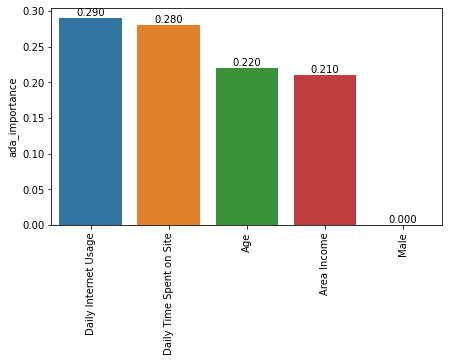

In [35]:
#plt.figure(figsize=(12,6))
ax = sns.barplot(data=ada_imp_feats,
                 x=ada_imp_feats.index, 
                 y='ada_importance')
ax.bar_label(ax.containers[0],fmt="%.3f");
plt.xticks(rotation=90);

## Evaluating ROC Curves and AUC

In [36]:
from sklearn.metrics import roc_auc_score,\
                            RocCurveDisplay, PrecisionRecallDisplay

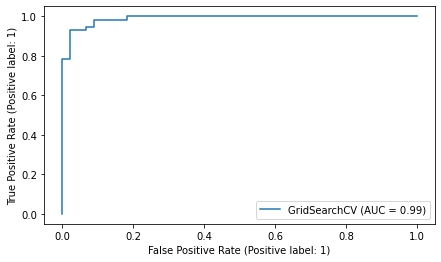

In [37]:
RocCurveDisplay.from_estimator(ada_grid_model, X_test, y_test);

## Gradient Boosting Modelling and Model Performance

![image.png](attachment:image.png)

![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [38]:
# gradient boosting algortiması hatalarını optimize etmek için gradinet descent algotimalarını kullanan tree based tabanlı
# bir modeldir.
# Her bir gözlemi sabit bir olasılıktan başlatılır. Datadaki 1 classları fazla ise bu olasılık 0.5'den büyük bir değer. 
# 0 classları fazla ise bu olasılık 0.5'den küçük bir değer olur. Bu olasılık değerini 1 ve 0 olasılık değrlerinden çıkararak
# residual değerlerini buluruz. Model bu residual değerlerini 0'a yakınsatarak tahminlerini mükemmeleştirmeye çalışıyor.

In [39]:
0.67 + (0.1* 0.33) + (0.1* 0.13) 

# Yukardaki görselde yeralan datamıza (6 tane 1 classı, 2 tane 0 classı var) özel tüm gözlemler 0.67 olasılıkla başlatılıyor.
# Datamızda 1 classı fazla olduğu için bu olasılık değeri 0.5'ten büyük (0.67) oldu. 

# ilk gözlem için ilk residual değeri 0.33, ikinci residual değeri 0.13

# Tüm gözlemlerin başlangıç olasılık değerine (0.67) her agaçta hesaplanan residual değeri ile learning rate çarpılıp ilave
# edilecek. Çıkan olasılık değeri modelin tahmini olacak. 

# learnin ratemizin 0.1 olduğunu varsyarak hesaplama yaptığımızda model ilk gözlemi 0.716 olasılıkla 1 classına atamıştır.

0.7160000000000001

In [40]:
0.67 + (0.1* -0.67) + (0.1* -0.44)

# Yukardaki görselde yeralan datamıza (6 tane 1 classı, 2 tane 0 classı var) özel tüm gözlemler 0.67 olasılıkla başlatılıyor.
# Datamızda 1 classı fazla olduğu için bu olasılık değeri 0.5'ten büyük (0.67) oldu. 

# ikinci gözlem için ilk residual değeri -0.67, ikinci residual değeri -0.44

# Tüm gözlemlerin başlangıç olasılık değerine (0.67) her agaçta hesaplanan residual değeri ile learning rate çarpılıp ilave
# edilecek. Çıkan olasılık değeri modelin tahmini olacak. 

# learnin ratemizin 0.1 olduğunu varsayarak hesaplama yaptığımızda model ikinci gözlemi 0.558 olasılıkla 1 classına atamıştır.

0.5589999999999999

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

In [42]:
grad_model = GradientBoostingClassifier(random_state=42)

# random foresttan farklı olarak:
# 1. Weak learner olabilmesi için default olarak max_dept=3 olarak düzenlenmiştir.
# 2. Tahmine her agacın ne kadar katkısı olacağı learning rate hyper parametresiyle düzenlenmiştir. defaultu 0.1'dir.
# 3. arka planda gradient descent tabanlı model kullanıldığından classificationda loss hyper parametresi vardır. Ve default 
# olarak log_loss'tur. Gradient boosting log_loss functionı ile residualleri minimize etmeye çalışır.
# 4. yaprakların dallanma kriteri olarak (criterion) mse'ye benzer birşekilde hesaplanan friedman_mse kullanılır. Model
# arka planda residualleri minimize etmeye çalıştığından regression modeli gibi çalışır.
# 5. subsample ile heragaçta ne kadar gözlem kullanılacağı tespit edilir. sub_sample=0.8 yaparsak her agaçta train datasından 
# rasgele seçtiği 0.8 oranındaki gözlemleri kullanır. Her agaç için bu işlem tekrarlanır. subsample düşürülürse overfitingi gidermeye yardımcı olur.
# 6. Diğer hyper_parametrelerin çoğu random forestle aynı veya benzerdir.

# Agaç sayısı veya learning rate arasındaki trade off iyi ayarlanmalıdır. Yoksa overfitinge gider.

In [43]:
grad_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [44]:
eval_metric(grad_model, X_train, y_train, X_test, y_test)

Test_Set
[[41  3]
 [ 2 54]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        44
           1       0.95      0.96      0.96        56

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100


Train_Set
[[456   0]
 [  1 443]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       444

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [45]:
model = GradientBoostingClassifier(random_state=42)

scores = cross_validate(model,
                        X_train,
                        y_train, 
                        scoring=['accuracy',
                                 'precision',
                                 'recall',
                                 'f1',
                                 'roc_auc'],
                        cv = 10, 
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy      0.952222
train_accuracy     0.999012
test_precision     0.958870
train_precision    1.000000
test_recall        0.945960
train_recall       0.997997
test_f1            0.951603
train_f1           0.998997
test_roc_auc       0.987972
train_roc_auc      0.999994
dtype: float64

## Gridsearch

In [46]:
param_grid = {"n_estimators":[100, 200, 300], 
              "subsample":[0.5, 1],
              "max_features" : [None, 2, 3, 4], 
              "learning_rate": [0.001, 0.01, 0.1], 
              'max_depth':[3,4,5,6]} #0.8

In [47]:
gb_model = GradientBoostingClassifier(random_state = 42)

In [48]:
grid = GridSearchCV(gb_model,
                    param_grid, 
                    scoring = "f1",
                    verbose=2, 
                    n_jobs=-1,
                    return_train_score=True)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': [None, 2, 3, 4],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.5, 1]},
             return_train_score=True, scoring='f1', verbose=2)

In [49]:
grid.best_estimator_

GradientBoostingClassifier(max_features=3, random_state=42, subsample=0.5)

In [50]:
pd.DataFrame(grid.cv_results_).loc[grid.best_index_, ["mean_test_score", "mean_train_score"]]

mean_test_score     0.965834
mean_train_score    0.995479
Name: 204, dtype: object

In [51]:
y_pred = grid.predict(X_test)
y_pred_proba = grid.predict_proba(X_test)

gb_f1 = f1_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_auc = roc_auc_score(y_test, y_pred_proba[:,1])

eval_metric(grid, X_train, y_train, X_test, y_test)

Test_Set
[[42  2]
 [ 2 54]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.96      0.96      0.96        56

    accuracy                           0.96       100
   macro avg       0.96      0.96      0.96       100
weighted avg       0.96      0.96      0.96       100


Train_Set
[[456   0]
 [  4 440]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       456
           1       1.00      0.99      1.00       444

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



## Feature importances

In [52]:
model = GradientBoostingClassifier(max_features= 3, 
                                   n_estimators = 100,
                                   subsample = 0.5, 
                                   random_state=42)
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns, 
                     data=model.feature_importances_, 
                     columns=['grad_importance'])
grad_imp_feats = feats.sort_values("grad_importance", ascending=False)
grad_imp_feats

,grad_importance
Daily Internet Usage,0.551346
Daily Time Spent on Site,0.319058
Area Income,0.074586
Age,0.053003
Male,0.002008


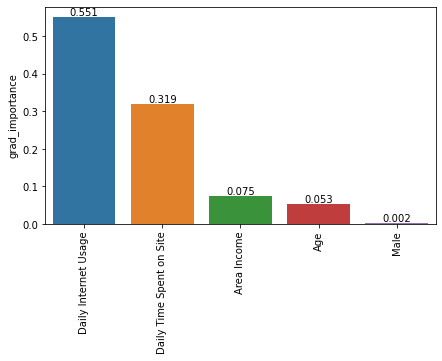

In [53]:
#plt.figure(figsize=(12,6))
ax = sns.barplot(data=grad_imp_feats, 
                 x=grad_imp_feats.index, 
                 y='grad_importance')
ax.bar_label(ax.containers[0],fmt="%.3f")
plt.xticks(rotation=90);

## Evaluating ROC Curves and AUC

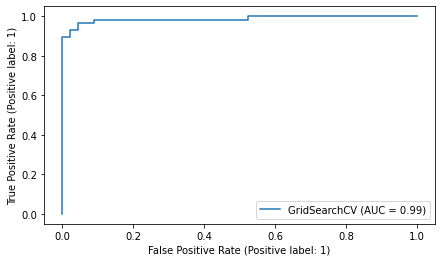

In [54]:
RocCurveDisplay.from_estimator(grid, X_test, y_test);

## XG Boosting Modelling and Model Performance

https://www.avato-consulting.com/?p=28903&lang=en

objective ve booster hyperparametreleriyle ilgili daha detaylı bilgi isteyenler okuyabilir.

In [55]:
from xgboost import XGBClassifier

In [56]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [57]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Hyper_parametreler:
# base_score=0.5 model tüm gözlemleri default 0.5 olasılık değerinden başlatıp bu değeri 1 classları için 1.0 olasılığına,
# 0 classları için 0.0 olasılığına çekmeye çalışır.

# max_depth=6, learning_rate=0.300000012 default değerleridir. Overfitinge en fazla etkisi olan parametrelerden bazılarıdır.

# subsample=1 default olarak tüm agaçlarda tüm gözlemleri kullanır. overiftingi engellemek için 0.8 civarı değerler denenmeli.
# subsumple=0.8 demek tüm agaçlarda train seti içinden rastgele %80 oranında gözlem seç ve agaçlarda bunları kullan. Her agaç
# için rastgele seçim tekrar yapılır. Bu işlem rassallığı artırır.

# colsample_bytree=1 default değeri 1 dir. Her agaç için kullanılması gereken feature sayısını belirler. datamız 20 featurdan
# oluşuyorsa ve colsample_bytree=0.5 ise her agaç için 20 featura içinden rastgele seçilen  10 feature kullanır sadece.
# rassalığı artırmak için kullanılır.

# colsample_bylevel=1 default değeri 1'dir. colsample_bylevel=0.5 ise her agaç için kullanılacak featurlar (10 feature) içinden 
# rastgele seçilen 5 feature her yaprak bölünmesi için kullınılır. Her yaprak bölünmesinde bu işlem tekrarlanır. rassalığı
# artırmak için kullanılır.

# gamma=0 default 0 dır. overfitingi engellemek için kullanılır. 0 ile + sonsuz arasında değer alabilir. gamma = 0 için 
# yorumlayalım. Bir kökün dallanması sonucunda loss functiondaki azalma 0'dan büyükse dallanmaya devam et. Train datasındaki 
# loss_funtionda bir azalma olmadığını gördüğü anda dallanmayı otomatik kesiyor. Yani dallanma için bir early_stop işlemi 
# görüyor diyebiliriz. gamma değerinde ufak tefek oynamalar yaparak overfiting giderilebiliyor.

# min_child_weight=1 default 1'dir. overfitingi engellemek için kullanılır. 0 ile + sonsuz arasında değer alır.
# min_child_weight=1 için yorumlayalım.Bir kökün dallanması sonucunda oluşan yeni bir yaprağa düşen gözlemlerin toplam ağırlığı 
# (eğer sample weights yapılmadıysa tüm gözlemlerin ağırlığı 1'dir) 1'den büyükse dallanmalar devam eder. Yani tüm gözlemlerin 
# ağırlığı 1'ken her yaprağa 1 gözlem düşene kadar dallanmalar devam eder.

# scale_pos_weight=1 ağılıklandırma parametresidir. Ancak sadece binary datalar için kullanılır. classların oranı 1/10 ise
# azınlık sınıfı ağırlıklandırmak için bu parametre 10 olarak düzenlenmelidir.

# reg_alpha = lasso, reg_lambda= ridge demek. default olarak ridge kullanılır.

# Her agaçtaki dallanmalar için gini, entrop veya mse gibi metricleri kullanmaz bunun yerine hesaplamının içine regularizasyon 
# parametresininde kullanıldığı similarity score diye bir parametre kullanır.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [58]:
eval_metric(xgb, X_train, y_train, X_test, y_test)

Test_Set
[[40  4]
 [ 3 53]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        44
           1       0.93      0.95      0.94        56

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100


Train_Set
[[456   0]
 [  0 444]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       444

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



In [59]:
model = XGBClassifier(random_state=42)

scores = cross_validate(model,
                        X_train, 
                        y_train, 
                        scoring=['accuracy', 
                                 'precision',
                                 'recall',
                                 'f1',
                                 'roc_auc'],
                        cv = 10, 
                        return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# fit fonksiyonu içerisinde tanımladığımız parametreyi CV içinde fit_params parametresinde belirtmemiz gerekiyor.

test_accuracy      0.956667
train_accuracy     1.000000
test_precision     0.966827
train_precision    1.000000
test_recall        0.945859
train_recall       1.000000
test_f1            0.955630
train_f1           1.000000
test_roc_auc       0.988984
train_roc_auc      1.000000
dtype: float64

## Gridsearch

In [60]:
param_grid = {"n_estimators":[50, 100, 200],
              'max_depth':[3,4,5], 
              "learning_rate": [0.1, 0.2],
              "subsample":[0.5, 0.8, 1], 
              "colsample_bytree":[0.5,0.7, 1]}

In [61]:
xgb_model = XGBClassifier(random_state=42) # default random_state=42

In [62]:
xgb_grid = GridSearchCV(xgb_model,
                        param_grid, 
                        scoring="f1",
                        verbose=2,
                        n_jobs=-1,
                        return_train_score=True)

xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'learning_rate': [0.1, 0.2], 'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.5, 0.8, 1]},
             return_train_score=True, scoring='f1', verbose=2)

In [63]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 50,
 'subsample': 0.8}

In [64]:
xgb_grid.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [65]:
pd.DataFrame(xgb_grid.cv_results_).loc[xgb_grid.best_index_, ["mean_test_score", "mean_train_score"]]

mean_test_score     0.967195
mean_train_score    0.980357
Name: 55, dtype: object

In [66]:
y_pred = xgb_grid.predict(X_test)
y_pred_proba = xgb_grid.predict_proba(X_test)

xgb_f1 = f1_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_auc = roc_auc_score(y_test, y_pred_proba[:,1])

eval_metric(xgb_grid, X_train, y_train, X_test, y_test)

Test_Set
[[40  4]
 [ 2 54]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        44
           1       0.93      0.96      0.95        56

    accuracy                           0.94       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.94      0.94      0.94       100


Train_Set
[[453   3]
 [ 15 429]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       456
           1       0.99      0.97      0.98       444

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



## Feature importances

In [67]:
model = XGBClassifier(n_estimators=50,
                      colsample_bytree=0.7,
                      subsample=0.8,
                      learning_rate=0.1,
                      max_depth= 3)
model.fit(X_train, y_train)

model.feature_importances_

feats = pd.DataFrame(index=X.columns,
                     data=model.feature_importances_,
                     columns=['xgb_importance'])
xgb_imp_feats = feats.sort_values("xgb_importance", ascending=False)
xgb_imp_feats

,xgb_importance
Daily Internet Usage,0.503184
Daily Time Spent on Site,0.276006
Age,0.104646
Area Income,0.097049
Male,0.019114


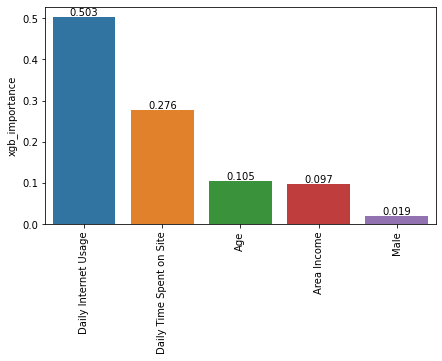

In [68]:
ax = sns.barplot(data=xgb_imp_feats, 
                 x=xgb_imp_feats.index,
                 y='xgb_importance')
ax.bar_label(ax.containers[0],fmt="%.3f")
plt.xticks(rotation=90);

## Feature importance comparison

In [69]:
pd.concat([ada_imp_feats, grad_imp_feats, xgb_imp_feats], axis=1)

,ada_importance,grad_importance,xgb_importance
Daily Internet Usage,0.29,0.551346,0.503184
Daily Time Spent on Site,0.28,0.319058,0.276006
Age,0.22,0.053003,0.104646
Area Income,0.21,0.074586,0.097049
Male,0.00,0.002008,0.019114


## Evaluating ROC Curves and AUC

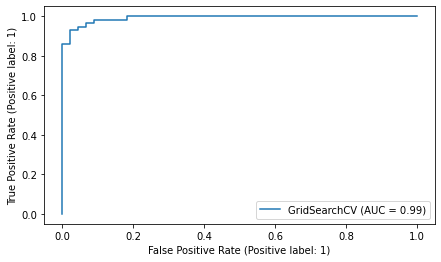

In [70]:
RocCurveDisplay.from_estimator(xgb_grid, X_test, y_test);

## Comparing Models

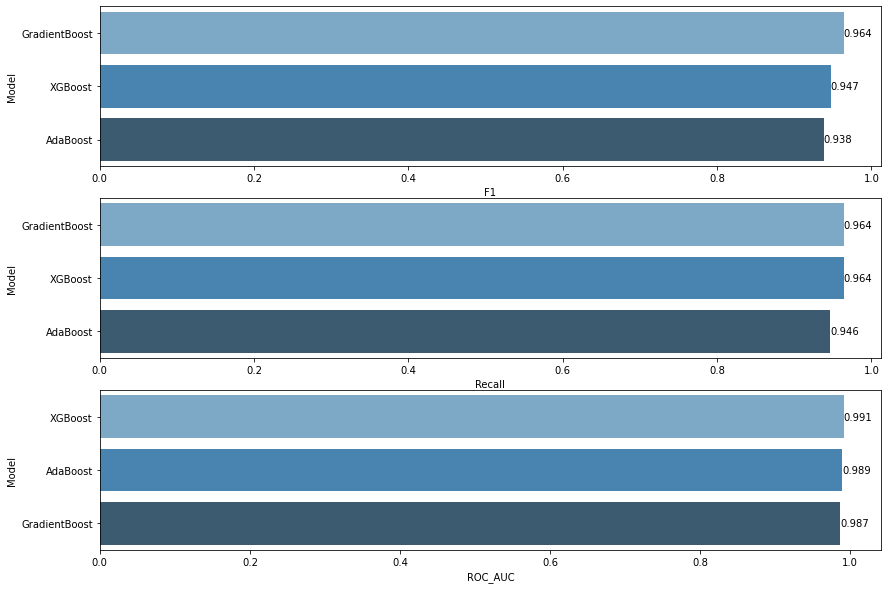

In [71]:
compare = pd.DataFrame({"Model": ["AdaBoost","GradientBoost", "XGBoost"],
                        "F1": [ada_f1, gb_f1, xgb_f1],
                        "Recall": [ada_recall, gb_recall, xgb_recall],
                        "ROC_AUC": [ada_auc, gb_auc, xgb_auc]})

    
plt.figure(figsize=(14,10))

plt.subplot(311)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0],fmt="%.3f")

plt.subplot(312)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0],fmt="%.3f")

plt.subplot(313)
compare = compare.sort_values(by="ROC_AUC", ascending=False)
ax=sns.barplot(x="ROC_AUC", y="Model", data=compare, palette="Blues_d")
ax.bar_label(ax.containers[0],fmt="%.3f")
plt.show()